## Importation des données

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
np.random.seed(6)
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [9]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [10]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goals, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time

In [74]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 200)
        self.fc2 = nn.Linear(200,200)
        self.fc3 = nn.Linear(200,300)
        self.fc4 = nn.Linear(300, 200)
        self.fc5 = nn.Linear(200, 1)
        self.bn1 = nn.BatchNorm1d(num_features=35)
        self.bn2 = nn.BatchNorm1d(num_features=200)
        self.bn3 = nn.BatchNorm1d(num_features=300)
        self.drop = nn.Dropout(p=0.15)
    
    def forward(self, x):
        x = self.fc1(self.drop(self.bn1(x)))
#         x = self.fc2(self.drop(self.bn2(x)))
#         x = self.fc3(self.drop(self.bn2(x)))
#         x = self.fc4(self.drop(self.bn3(x)))
        x = self.fc5(self.drop(self.bn2(x)))
        return x

In [13]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [75]:
def train(train_data, train_labels, nepochs):
    
    trainset = hockey_dataset(train_data[:train_size], train_labels[:train_size])
    validset = hockey_dataset(train_data[train_size:], train_labels[train_size:])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle = False)
    
    network = Network().to(device)
    criterion = nn.MSELoss()
    lr = 0.003
    optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        if (epoch > 0) and (epoch%150 == 0):
            lr = lr*0.75
            optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.01, momentum = 0)
        current_loss_train, current_loss_valid = 0,0
        network.train()
        for data in trainloader:
            inputs, label = data
            optimizer.zero_grad()
            output = network(inputs.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            current_loss_train += loss.item()/train_size
        if epoch%5 == 0:
                loss_train.append(current_loss_train)
        
        with torch.no_grad():
            network.eval()
            for data in validloader:
                inputs, label = data

                output = network(inputs.to(device))
                loss = criterion(output, label.to(device))
                current_loss_valid += loss.item()/valid_size
            if epoch%5 == 0:
                loss_valid.append(current_loss_valid)
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train loss: {0:.4f}'.format(loss_train[-1]))
            print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Finished Training')
    
    print('Mean loss of last 50 iterations(test): ',np.array(loss_train[-50:]).mean())
    print('Mean loss of last 50 iterations(valid): ',np.array(loss_valid[-50:]).mean())
    
    return loss_train, loss_valid, network

In [59]:
def predict(network, test_data, test_labels):
    testset = hockey_dataset(test_data, test_labels)
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle = False)
    
    network.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, label = data
            predictions = network(inputs.to(device))
    return predictions.cpu().numpy()

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

In [61]:
# nepochs = 1001
# t1 = time.time()
# loss_train, loss_valid, network = train(training_data, training_targets_primary_assists, nepochs)
# print("Temps d'entrainement : {}".format(time.time()-t1))

# plt.style.use('ggplot')
# fig,ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
# ax1, ax2 = ax.flatten()
# ax1.plot(range(1,nepochs,5), loss_train[1:], 'k,-', label='Train')
# ax1.plot(range(1,nepochs,5), loss_valid[1:], 'r,-', label='Valid')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Average Loss')
# ax1.legend()

# ax2.plot(range(20,nepochs,5), loss_train[4:], 'k,-', label='Train')
# ax2.plot(range(20,nepochs,5), loss_valid[4:], 'r,-', label='Valid')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Average Loss')
# ax2.legend()
# plt.show()
# plt.close()

In [62]:
# predictions = predict(network=network, test_data=test_data, test_labels=test_targets_primary_assists)

# plt.style.use('ggplot') 
# fig,ax = plt.subplots(figsize=(10,10))

# ax.scatter(test_targets_primary_assists, predictions, c = 'b')
# #ax1.scatter(training_targets_goals, predictions_train[0], c = 'r')
# ax.plot([0,np.max(test_targets_primary_assists)],[0,np.max(test_targets_primary_assists)], 'k')
# ax.set_xlabel('Real Goals')
# ax.set_ylabel('Predicted Goals')
# ax.set_title('Points Predictions')

Epoch: 0
Train loss: 0.2606
Valid loss: 1.2359
Epoch: 100
Train loss: 0.0246
Valid loss: 0.1616
Epoch: 200
Train loss: 0.0213
Valid loss: 0.1585
Epoch: 300
Train loss: 0.0232
Valid loss: 0.1595
Epoch: 400
Train loss: 0.0226
Valid loss: 0.1607
Epoch: 500
Train loss: 0.0214
Valid loss: 0.1606
Epoch: 600
Train loss: 0.0220
Valid loss: 0.1601
Epoch: 700
Train loss: 0.0241
Valid loss: 0.1604
Epoch: 800
Train loss: 0.0240
Valid loss: 0.1603
Epoch: 900
Train loss: 0.0219
Valid loss: 0.1612
Epoch: 1000
Train loss: 0.0218
Valid loss: 0.1612
Finished Training
Mean loss of last 50 iterations(test):  0.022274567923997415
Mean loss of last 50 iterations(valid):  0.16096779812587783
Temps d'entrainement : 11.793906688690186
Epoch: 0
Train loss: 0.6691
Valid loss: 3.1654
Epoch: 100
Train loss: 0.0433
Valid loss: 0.3674
Epoch: 200
Train loss: 0.0511
Valid loss: 0.3677
Epoch: 300
Train loss: 0.0520
Valid loss: 0.3628
Epoch: 400
Train loss: 0.0474
Valid loss: 0.3672
Epoch: 500
Train loss: 0.0543
Valid l

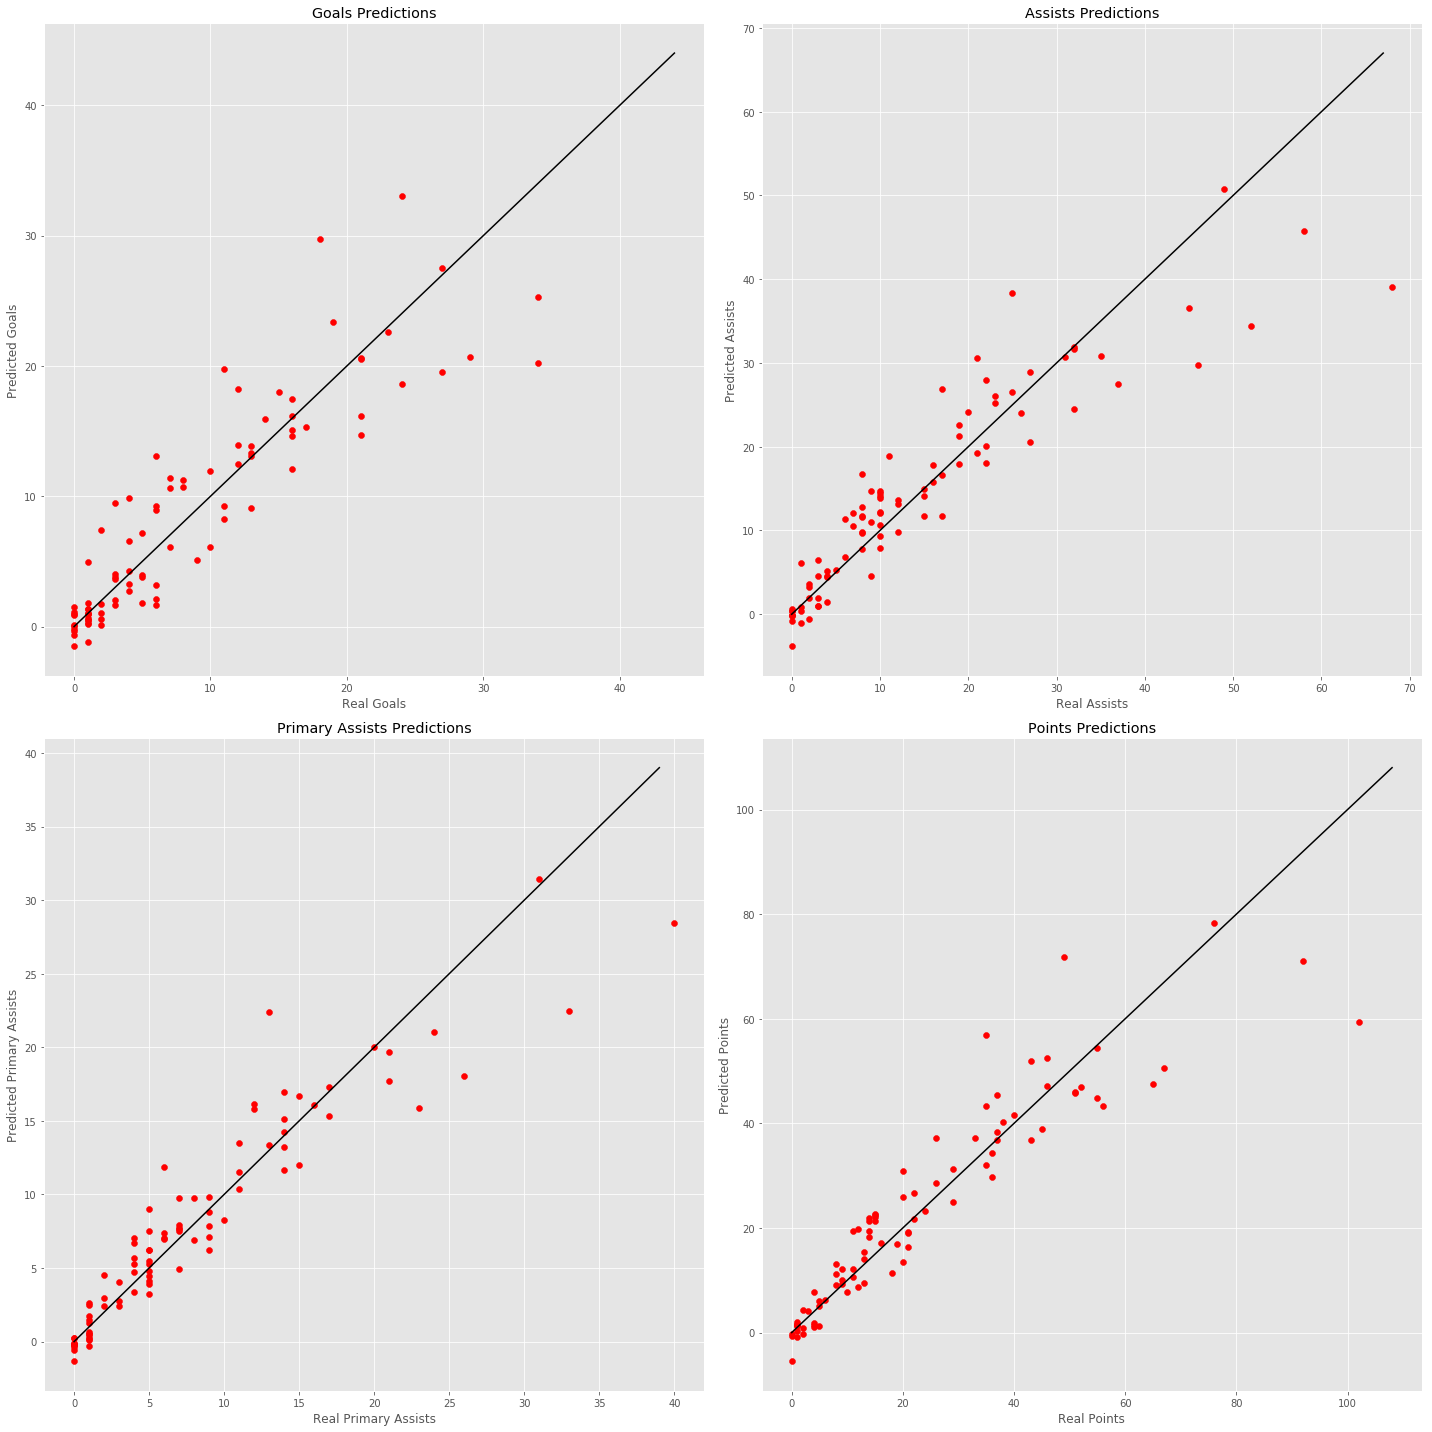

In [76]:
nepochs = 1001
predictions = []
for targets in [[training_targets_goals, test_targets_goals],
                [training_targets_assists, test_targets_assists],
                [training_targets_primary_assists, test_targets_primary_assists],
                [training_targets_points, test_targets_points]]:

    t1 = time.time()
    loss_train, loss_valid, network = train(training_data, targets[0], nepochs)
    print("Temps d'entrainement : {}".format(time.time()-t1))
#     predictions_test = predict(network, test_data, targets[1])
#     predictions.append(predictions)
    predictions_valid = predict(network, training_data[train_size:], targets[0][train_size:])
    predictions.append(predictions_valid)
    

plt.style.use('ggplot') 
fig,ax = plt.subplots(nrows=2, ncols=2, figsize = (20,20))
ax1, ax2, ax3, ax4 = ax.flatten()

#ax1.scatter(test_targets_goals, predictions[0], c = 'b')
ax1.scatter(training_targets_goals[train_size:], predictions[0], c = 'r')
ax1.plot([0,np.max(test_targets_goals)],[0,np.max(test_targets_goals)], 'k')
ax1.set_xlabel('Real Goals')
ax1.set_ylabel('Predicted Goals')
ax1.set_title('Goals Predictions')

#ax2.scatter(test_targets_assists, predictions[1], c = 'b')
ax2.scatter(training_targets_assists[train_size:], predictions[1], c = 'r')
ax2.plot([0,np.max(test_targets_assists)],[0,np.max(test_targets_assists)], 'k')
ax2.set_xlabel('Real Assists')
ax2.set_ylabel('Predicted Assists')
ax2.set_title('Assists Predictions')

#ax3.scatter(test_targets_primary_assists, predictions[2], c = 'b')
ax3.scatter(training_targets_primary_assists[train_size:], predictions[2], c = 'r')
ax3.plot([0,np.max(test_targets_primary_assists)],[0,np.max(test_targets_primary_assists)], 'k')
ax3.set_xlabel('Real Primary Assists')
ax3.set_ylabel('Predicted Primary Assists')
ax3.set_title('Primary Assists Predictions')

#ax4.scatter(test_targets_points, predictions[3], c = 'b')
ax4.scatter(training_targets_points[train_size:], predictions[3], c = 'r')
ax4.plot([0,np.max(test_targets_points)],[0,np.max(test_targets_points)], 'k')
ax4.set_xlabel('Real Points')
ax4.set_ylabel('Predicted Points')
ax4.set_title('Points Predictions')

fig.tight_layout()
plt.savefig('predictions.png')

In [46]:
# pred_goals = predictions_test[0]
# pred_assists = predictions_test[1]
# pred_primary_assists = predictions_test[2]
# pred_points = predictions_test[3]
# # pred_plusminus = predictions_test[4]

In [77]:
targets_list = [training_targets_goals[train_size:], training_targets_assists[train_size:],
                training_targets_primary_assists[train_size:], training_targets_points[train_size:]]
# targets_list = [test_targets_goals, test_targets_assists,
#                 test_targets_primary_assists, test_targets_points]
treshold_list = [5, 7, 5, 10]
std, deviations = [], []
for pred, target, treshold in zip(predictions, targets_list, treshold_list) :
    not_small = np.where(target > treshold)[0]
    deviations.append((pred[not_small] - target[not_small]) / target[not_small])
    std.append(np.std(deviations[-1]))

In [78]:
std

[0.38623208, 0.3102845, 0.25803676, 0.28407905]

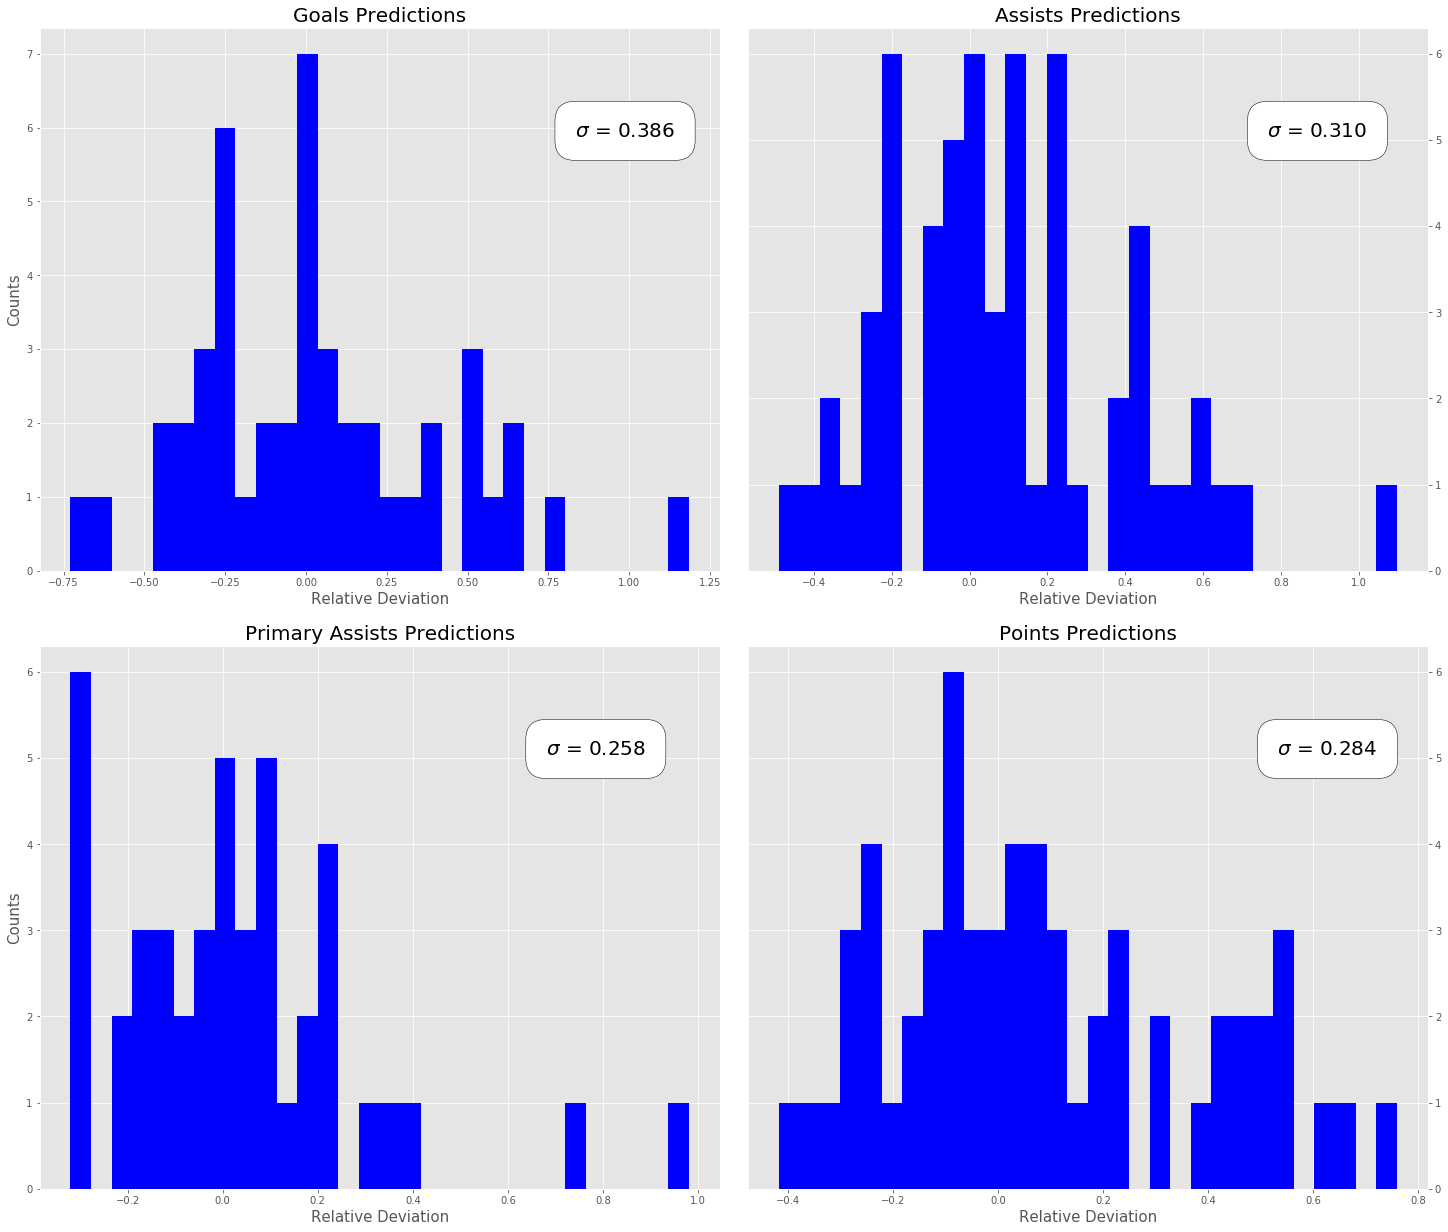

In [79]:
fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(20,17))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.hist(deviations[0], bins=30, color='b')
ax1.set_title('Goals Predictions', fontsize=20)
ax1.set_xlabel('Relative Deviation', fontsize=15)
ax1.set_ylabel('Counts', fontsize=15)
ax1.text(0.65*ax1.get_xlim()[1], 0.8*ax1.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[0]), color='black', 
        fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                  boxstyle='round,pad=1'))

ax2.hist(deviations[1], bins=30, color='b')
ax2.yaxis.tick_right()
ax2.set_title('Assists Predictions', fontsize=20)
ax2.set_xlabel('Relative Deviation', fontsize=15)
ax2.text(0.65*ax2.get_xlim()[1], 0.8*ax2.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[1]), color='black', 
        fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                  boxstyle='round,pad=1'))

ax3.hist(deviations[2], bins=30, color='b')
ax3.set_title('Primary Assists Predictions', fontsize=20)
ax3.set_xlabel('Relative Deviation', fontsize=15)
ax3.set_ylabel('Counts', fontsize=15)
ax3.text(0.65*ax3.get_xlim()[1], 0.8*ax3.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[2]), color='black', 
        fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                  boxstyle='round,pad=1'))

ax4.hist(deviations[3], bins=30, color='b')
ax4.yaxis.tick_right()
ax4.set_title('Points Predictions', fontsize=20)
ax4.set_xlabel('Relative Deviation', fontsize=15)
ax4.text(0.65*ax4.get_xlim()[1], 0.8*ax4.get_ylim()[1], '$\sigma$ = {:5.3f}'.format(std[3]), color='black', 
        fontsize = 20, bbox=dict(facecolor='w', edgecolor='black', 
                  boxstyle='round,pad=1'))

plt.show()